In [1]:
%load_ext autoreload
%autoreload 2
import sys
import collections
import numpy as np
import re
import os
# sys.path.append("/private/home/alexandrerame/domainbedv2/")
sys.path.append("/Users/alexandrerame/code_repository/dataplace/data/logs_experiments_notebook")
sys.path.append("/Users/alexandrerame/code_repository/codedev/domainbedv2")

# sys.path.append("/home/rame/domainbedv2/")
from domainbed.codeplot import plot
plot.plt.style.use('default')
# sys.path.append("/data/rame/logs_experiments_notebook/nlp")
from matplotlib import rc

rc('text', usetex=True)
plot.plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]
plot.plt.rcParams['text.usetex'] = True
plot.plt.rcParams['font.family'] = 'serif'


In [2]:
# %load_ext autoreload
# %autoreload 2
# import sys
# import collections
# import numpy as np
# # sys.path.append("/private/home/alexandrerame/domainbedv2/")
# # sys.path.append("/private/home/alexandrerame/slurmconfig/notebook/data")

# sys.path.append("/home/rame/domainbedv2/")

# from domainbed.codeplot import plot
# plot.plt.style.use('default')
# sys.path.append("/data/rame/logs_experiments_notebook/")

In [3]:
plot.dict_key_to_label.update(
    {
        "ROUGE_L": r"$R_2$: $ROUGE$",
        "Bleu_1": r"$R_1$: $BLEU1$",
        "Bleu_4": r"$R_2$: $BLEU4$",
        "METEOR": r"$R_2$: $METEOR$",
        "CIDEr": r"$R_2$: $CIDEr$"
    }
)
dict_colormaps = plot.create_colormaps()
cmap_redpurpleblue = plot.matplotlib.colors.LinearSegmentedColormap.from_list(
    "", [
        plot.get_color_from_cmap("Reds", dict_colormaps),
        plot.get_color_from_cmap("Purples", dict_colormaps),
        plot.get_color_from_cmap("Blues", dict_colormaps)
    ]
)
cmap_redgreenblue = plot.matplotlib.colors.LinearSegmentedColormap.from_list(
    "", [
        plot.get_color_from_cmap("Reds", dict_colormaps),
        (125 / 255, 150 / 255, 250 / 255),
        plot.get_color_from_cmap("Blues", dict_colormaps)
    ]
)

do_save = True


In [4]:
from captioning import fts_bleu4, fts_bleu, fts_rouge, fts_meteor, fts_bleurouge, fts_bleumeteor, fts_bleubleu4, fts_rougebleu4, fts_cider, fts_ciderbleu, fts_rougecider
from captioning import e2e_bleu, e2e_bleu4, e2e_rouge, e2e_bleurouge, e2e_bleu4rouge, e2e_meteor, e2e_bleubleu4, e2e_bleumeteor, e2e_cider

In [5]:
do_save=True
def get_at_coeff(l_wa, coeff=0.5):
    for l in l_wa:
        if isinstance(l["lambda"], list):
            found_coeff = l["lambda"][0]
        else:
            found_coeff = l["lambda"]
        if found_coeff == coeff:
            return l
    raise ValueError()
arrowprops = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)
arrowpropsinv = dict(arrowstyle='->', connectionstyle='arc3,rad=-0.2', linewidth=1, shrinkA=0)
dict_key_to_label = {
    "ROUGE_L": "ROUGE",
    "Bleu_1": "BLEU1",
    "Bleu_2": "BLEU2",
    "Bleu_3": "BLEU3",        
    "Bleu_4": "BLEU4",
    "METEOR": "METEOR",
    "CIDEr": "CIDEr"
}

In [6]:
list_e2e = [
    e2e_bleubleu4.l_wa_bleu4bleu, e2e_bleumeteor.l_wa_meteorbleu, e2e_bleurouge.l_wa_rougebleu,
    e2e_bleu4rouge.l_wa, fts_bleu.l_step
]
list_fts = [
    fts_bleubleu4.l_wa,
    fts_bleumeteor.l_wa,
    fts_bleurouge.l_wa_epoch5,
    fts_rougebleu4.l_wa,
    # fts_ciderbleu.l_wa
    fts_bleu.l_step
]
import math
def get_minmax(list_ls):
    dict_key_to_minmax = {
        "ROUGE_L": [math.inf, -math.inf],
        "Bleu_1": [math.inf, -math.inf],
        "Bleu_2": [math.inf, -math.inf],
        "Bleu_3": [math.inf, -math.inf],        
        "Bleu_4": [math.inf, -math.inf],
        "METEOR": [math.inf, -math.inf],
        "CIDEr": [math.inf, -math.inf]
    }
    for l in list_ls:
        for line in l:
            if line["lambda"] not in [0,1]:
                continue
            for key in dict_key_to_minmax:
                dict_key_to_minmax[key][0] = min(
                    dict_key_to_minmax[key][0],
                    line[key]
                )
    for key in dict_key_to_minmax:
        dict_key_to_minmax[key][1] = max(
            dict_key_to_minmax[key][1],
            fts_bleu.l_step[0][key])
    for key in dict_key_to_minmax.keys():
        dict_key_to_minmax[key].append(
            dict_key_to_minmax[key][1] - dict_key_to_minmax[key][0]
        )
    return dict_key_to_minmax


dict_key_to_minmax_fts = get_minmax(list_fts)
dict_key_to_minmax_e2e = get_minmax(list_e2e)

In [7]:
dict_key_to_minmax_fts

{'ROUGE_L': [0.5994, 0.6059, 0.00649999999999995],
 'Bleu_1': [0.7838, 0.8321, 0.0482999999999999],
 'Bleu_2': [0.6298, 0.6864, 0.056599999999999984],
 'Bleu_3': [0.4861, 0.5408, 0.05469999999999997],
 'Bleu_4': [0.3674, 0.4168, 0.0494],
 'METEOR': [0.299, 0.3036, 0.004599999999999993],
 'CIDEr': [1.3168, 1.3965, 0.0797000000000001]}

In [8]:
clean_kwargs_scatter = {
    "key_x":
    "1-lambda",
    "loc":
    "lower center",
    "colors": [
        plot.get_color_from_cmap(cmp, dict_colormaps=dict_colormaps) for cmp in
        ["Blues", "fake_cyan", "fake_royalblue", "Dark_Blues", "Reds", "Oranges", "Yellows"]
    ],
    "order":
    "3",
    "title":
    None,
    "fontsize":
    "xx-large",
    "_dict_key_to_limit": {},  # "x": (0., 1.), "y": (0, 1.08)},
    "_dict_key_to_label": {
        "1-lambda": r'$\lambda$',
        "lambda": r'$\lambda$',
        "METEOR": "METEOR",
        "CIDEr": "CIDEr"
    }
}
keys_y=["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4", "ROUGE_L", "METEOR", "CIDEr"]

dict_key_to_marker = {
    "Bleu_1": 'v',
    "Bleu_2": '<',
    "Bleu_3": '>',
    "Bleu_4":  '^',
    "ROUGE_L": 's',
    "METEOR": 'p',
    "CIDEr": "o",
}
def plot_scatter_captioning(l, key_1, key_2, dict_key_to_minmax=dict_key_to_minmax_fts, legendtitle=None, keys_y=keys_y, **kwargs):
    label_1 = dict_key_to_label[key_1]
    label_2 = dict_key_to_label[key_2]
    if legendtitle is None:
        legendtitle = r"RS: $(1-\lambda)\cdot\theta_{{{label_1}}}$".format(
            label_1=label_1
        ) + r"$ + \lambda\cdot\theta_{{{label_2}}}$".format(label_2=label_2)
    if legendtitle == "no":
        legendtitle = None

    plot.plt.rcParams["figure.figsize"] = (6, 6)
    for key in clean_kwargs_scatter.keys():
        if key not in kwargs:
            kwargs[key] = clean_kwargs_scatter[key]
    suffixes = [r"$R_1$: " if key == key_1 else (r"$R_2$: " if key == key_2 else "") for key in keys_y]
    labels = [suffix + r"${l}$".format(l=dict_key_to_label[key]) for suffix, key in zip(suffixes, keys_y)]
    print(labels)
    markers = ["*" if key in [key_1, key_2] else dict_key_to_marker[key] for key in keys_y]
    linestyles = ["dotted" if key in [key_1, key_2] else "solid" for key in keys_y]
    kwargs["keys_y"] = [
        key + "-" + str(dict_key_to_minmax[key][0]) + "/" + str(dict_key_to_minmax[key][2]) for key in keys_y]
    fig_dr = plot.plot_basic_scatter(
        l,
        labels=labels,
        markers=markers,
        linestyles=linestyles,
        legendtitle=legendtitle,
        **kwargs,

    )
    plot.plt.rcParams["figure.figsize"] = (6, 6)
    return fig_dr

In [9]:
clean_kwargs = {"loc": "no", "order": "savgol_3_1_quadratic", "list_indexes": [0, 2, 4, 5], "linewidths": [1,1,1,1,1,3],
        "colormaps": ['Blues', 'Blues', 'Reds', 'Reds', 'Purples', "Greens"],
        "linestyles": ['dotted', 'dashed', 'dotted', 'dashed', "dotted", 'solid'],
        "fontsize": "xx-large"
                }
SIZE_PLOT="xx-large"
def plot_captioning(list_l, key_x, key_y, do_annotate=True, dict_annotation_to_loc={}, labels=None, dict_labels={}, **kwargs):
    for key in clean_kwargs.keys():
        if key not in kwargs:
            kwargs[key] = clean_kwargs[key]

    label_x = dict_key_to_label[key_x]
    label_y = dict_key_to_label[key_y]
    label_xy = "{label_x} + {label_y}".format(label_x=label_x, label_y=label_y)
    # labels = [
    #     r"RL: ${label_x}$".format(label_x=label_x
    #                                     ), r"WA: $init$ $\to$ ${label_x}$".format(label_x=label_x),
    #     r"RL: ${label_y}$".format(label_y=label_y),
    #     r"WA: $init$ $\to$ ${label_y}$".format(label_y=label_y),
    #     r"RL: $\frac{{{label_xy}}}{{2}}$".format(label_xy=label_xy),
    #     r"WA: ${label_x}$ $\to$ ${label_y}$".format(label_x=label_x, label_y=label_y)
    # ]
    if labels is None:
        labels = [
                r"RL: ${label_x}$".format(label_x=label_x),
                r"WA: $init$ $\to$ ${label_x}$".format(label_x=label_x),
                r"RL: ${label_y}$".format(label_y=label_y),
                r"WA: $init$ $\to$ ${label_y}$".format(label_y=label_y),
                r"MORL: $\frac{{{label_xy}}}{{2}}$".format(label_xy=label_xy),
                r"RS: $(1-\lambda) \cdot \theta_{{{label_x}}} + \lambda \cdot \theta_{{{label_y}}}$".format(label_x=label_x, label_y=label_y)            
                # r"RS: $(1-\lambda) \cdot \theta_{1} + \lambda \cdot \theta_{2}$"
            ]
    for key, label in dict_labels.items():
        labels[key] = label
    fig_dr = plot.plot_key(
        list_l,
        key_x=key_x,
        key_y=key_y,
        labels=labels,
        **kwargs
    )
    if do_annotate:
        arrowprops.update({"relpos": (0.5, 1)})
        plot.plt.annotate(
            "pre-trained init",
            xy=(list_l[0][0][key_x], list_l[0][0][key_y]),
            xytext=dict_annotation_to_loc.get("pt"),
            ha='left',
            va="top",
            size=SIZE_PLOT,
            arrowprops=arrowprops
        )
        arrowprops.update({"relpos": (0.5, 0)})
        plot.plt.annotate(
            r"${label_x}$".format(label_x=label_x) + " rewarded",
            xy=(list_l[0][-1][key_x], list_l[0][-1][key_y]),
            xytext=dict_annotation_to_loc.get("0"),
            ha='right',
            va="bottom",
            size=SIZE_PLOT,
            arrowprops=arrowprops
        )
        arrowprops.update({"relpos": (0.5, 1)})
        plot.plt.annotate(
            r"${label_y}$".format(label_y=label_y) + " rewarded",
            xy=(list_l[2][-1][key_x], list_l[2][-1][key_y]),
            xytext=dict_annotation_to_loc.get("1"),
            ha='left',
            va="top",
            size=SIZE_PLOT,
            arrowprops=arrowprops
        )
        arrowpropsinv.update({"relpos": (0.5, 0)})
        plot.plt.annotate(
            r"$\frac{{{label_xy}}}{{2}}$".format(label_xy=label_xy) + " rewarded",
            xy=(list_l[4][-1][key_x], list_l[4][-1][key_y]),
            xytext=dict_annotation_to_loc.get("01"),
            ha='left',
            va="bottom",
            size=SIZE_PLOT,
            arrowprops=arrowpropsinv
        )
        if dict_annotation_to_loc.get("lambda") == "right":
            arrowprops.update({"relpos": (0.5, 0)})
            plot.plt.annotate(
                r"$\lambda=0.5$",
                xy=(get_at_coeff(list_l[5])[key_x], get_at_coeff(list_l[5])[key_y]),
                ha='right',
                va="bottom",
                size=SIZE_PLOT,
                arrowprops=arrowprops
            )
        else:
            arrowprops.update({"relpos": (0.5, 1)})
            plot.plt.annotate(
                r"$\lambda=0.5$",
                xy=(
                    get_at_coeff(list_l[5])[key_x],
                    get_at_coeff(list_l[5])[key_y]
                ),
                xytext=dict_annotation_to_loc.get("lambda"),
                ha='left',
                va="top",
                size=SIZE_PLOT,
                arrowprops=arrowprops
            )
        del arrowprops["relpos"]
    return fig_dr

# bleu to bleu4

In [14]:
plot.plt.rcParams["figure.figsize"] = (6, 6)

In [ ]:
fig_dr = plot_scatter_captioning(l=e2e_bleubleu4.l_wa_bleu4bleu, key_1="Bleu_1", key_2="Bleu_4", dict_key_to_minmax=dict_key_to_minmax_e2e, fontsize="xx-large", _dict_key_to_limit={"y": (-0.02, 1.65)})
# plot.save_fig(fig=fig_dr, name="captioning/lambda_captioning_e2e_bleu1tobleu4.pdf", do_save=do_save)


In [ ]:
fig_dr = plot_captioning(
    list_l=[
        e2e_bleu.l_step, e2e_bleu.l_wa, e2e_bleu4.l_step, e2e_bleu4.l_wa, e2e_bleubleu4.l_step,
        e2e_bleubleu4.l_wa_bleu4bleu
    ],
    key_x="Bleu_1",
    key_y="Bleu_4",
    dict_annotation_to_loc={
        "01": (0.833, 0.424),
        "01": (0.833, 0.424),        
        "lambda": (0.85, 0.42),
    },
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_e2e_bleu1tobleu4.pdf", do_save=do_save)


In [ ]:
fig_dr = plot_scatter_captioning(l=fts_bleubleu4.l_wa, key_1="Bleu_1", key_2="Bleu_4", order="3", dict_key_to_minmax=dict_key_to_minmax_fts, _dict_key_to_limit={"y": (-0.02, 1.75)})
plot.save_fig(fig=fig_dr, name="captioning/lambda_captioning_bleu1tobleu4.pdf", do_save=do_save,)


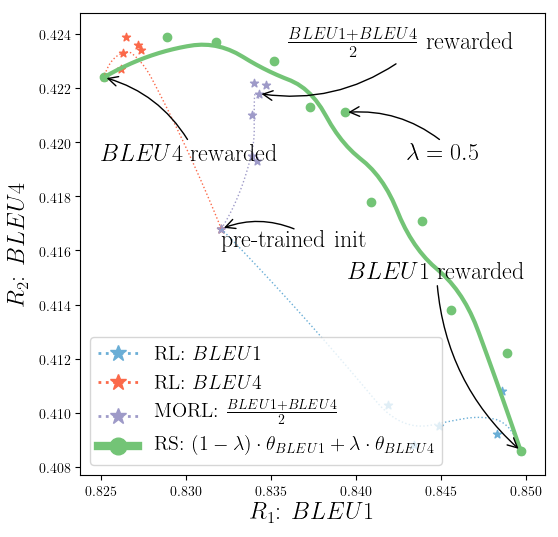

In [47]:
fig_dr = plot_captioning(
    list_l=[
        fts_bleu.l_step, fts_bleu.l_wa, fts_bleu4.l_step, fts_bleu4.l_wa, fts_bleubleu4.l_step,
        fts_bleubleu4.l_wa
    ],
    key_x="Bleu_1",
    key_y="Bleu_4",
    dict_labels={
        0: r"RL: $BLEU1$",
        2: r"RL: $BLEU4$",
        4: r"MORL: $\frac{BLEU1+BLEU4}{2}$",
        5: r"RS: $(1-\lambda) \cdot \theta_{BLEU1} + \lambda \cdot \theta_{BLEU4}$"
    },
    loc="lower left",
    fontsize="x-large",
    dict_annotation_to_loc={
        "01": (0.836, 0.423),
        "0": (0.85, 0.4148),
        "1": (0.825, 0.42),
        "lambda": (0.843, 0.42),
    },
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleu1tobleu4.pdf", do_save=do_save)


# bleu to meteor

In [ ]:
fig_dr = plot_scatter_captioning(
    l=e2e_bleumeteor.l_wa_meteorbleu,
    key_1="Bleu_1",
    key_2="METEOR",
    order="3",
    dict_key_to_minmax=dict_key_to_minmax_e2e,
    _dict_key_to_limit={"y": (-0.02, 1.65)}
    # _dict_key_to_limit={
    #     "x": (0., 1.),
    #     "y": (0, 1.15)
    # }
)
plot.save_fig(
    fig=fig_dr,
    name="captioning/lambda_captioning_e2e_bleu1tometeor.pdf",
    do_save=do_save,
)


In [ ]:
fig_dr = plot_captioning(
    list_l=[
        e2e_bleu.l_step, e2e_bleu.l_wa, e2e_meteor.l_step, e2e_meteor.l_wa, e2e_bleumeteor.l_step,
        e2e_bleumeteor.l_wa_meteorbleu
    ],
    key_x="Bleu_1",
    key_y="METEOR",
    dict_annotation_to_loc={
        "pt": (0.82, 0.30),
        # "1": (0.808, 0.311),
        "1": (0.79, 0.305),
        "01": (0.821, 0.3100),
        "lambda": (0.823, 0.3085)
    }
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_e2e_bleu1tometeor.pdf", do_save=do_save)


In [ ]:
fig_dr = plot_scatter_captioning(l=fts_bleumeteor.l_wa, key_1="Bleu_1", key_2="METEOR", order="3", _dict_key_to_limit={"y": (-0.02, 2.95)}, loc="upper center")
plot.save_fig(
    fig=fig_dr,
    name="captioning/lambda_captioning_bleu1tometeor.pdf",
    do_save=do_save,
)


Failed for label: MORL: $\frac{BLEU1 + METEOR}{2}$ because: Expect x to be a 1-D sorted array_like.


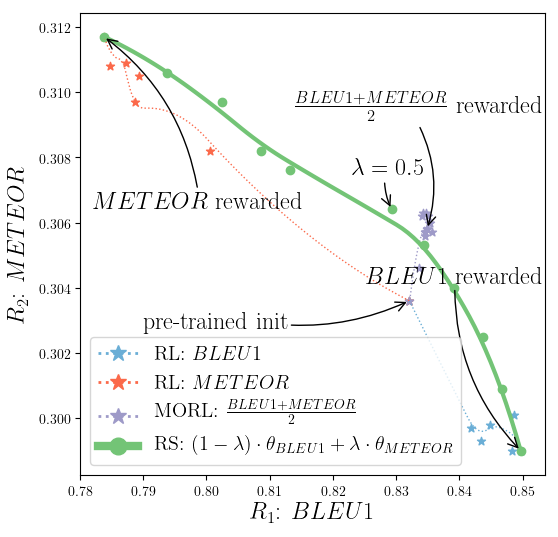

In [37]:
fig_dr = plot_captioning(
    list_l=[
        fts_bleu.l_step,
        fts_bleu.l_wa,
        fts_meteor.l_step,
        fts_meteor.l_wa,
        fts_bleumeteor.l_step,
        fts_bleumeteor.l_wa,
    ],
    loc="lower left",
    key_x="Bleu_1",
    key_y="METEOR",
    fontsize="x-large",
    dict_annotation_to_loc={"pt": (0.79, 0.3033), "1": (0.782, 0.307), "lambda": (0.823, 0.308), "01": (0.814, 0.309), "0": (0.8533, 0.304)}
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleu1tometeor.pdf", do_save=do_save)

# Bleu to ROUGE

['$R_1$: $BLEU1$', '$BLEU2$', '$BLEU3$', '$BLEU4$', '$R_2$: $ROUGE$', '$METEOR$', '$CIDEr$']


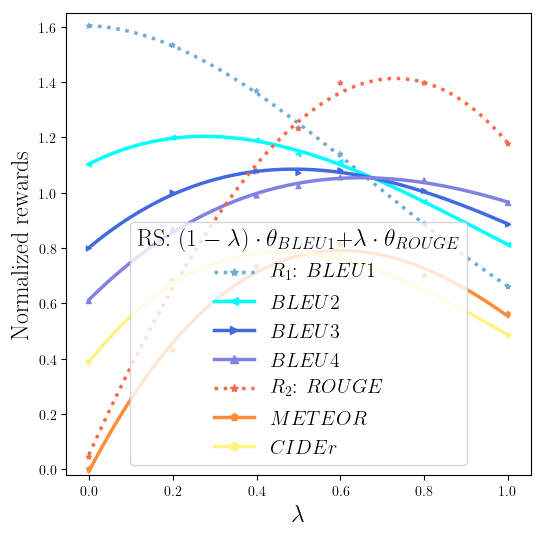

In [27]:
fig_dr = plot_scatter_captioning(
    l=e2e_bleurouge.l_wa_rougebleu,
    key_1="Bleu_1",
    key_2="ROUGE_L",
    order="3",
    key_x="1-lambda",
    _dict_key_to_limit={"y": (-0.02, 1.65)},
    dict_key_to_minmax=dict_key_to_minmax_e2e
)
plot.save_fig(
    fig=fig_dr,
    name="captioning/lambda_captioning_e2e_bleu1torouge.pdf",
    do_save=do_save,
)


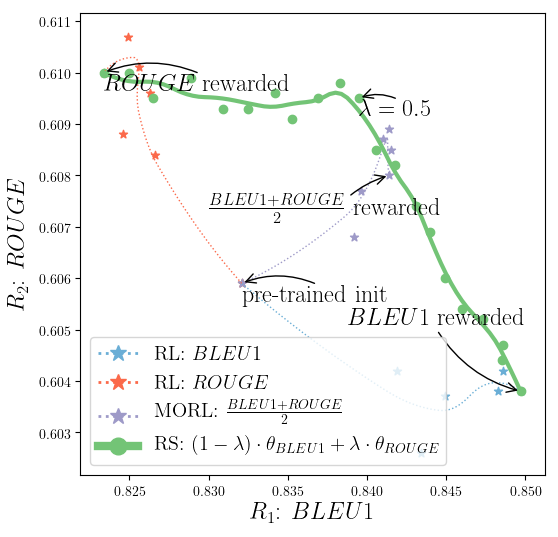

In [17]:
fig_dr = plot_captioning(
    [
        fts_bleu.l_step, None, fts_rouge.l_step, None,
        fts_bleurouge.l_step, fts_bleurouge.l_wa_epoch5
    ],
    key_x="Bleu_1",
    key_y="ROUGE_L",
    loc="lower left",
    dict_labels={
        0: r"RL: $BLEU1$",
        2: r"RL: $ROUGE$",
        4: r"MORL: $\frac{BLEU1+ROUGE}{2}$",
        5: r"RS: $(1-\lambda) \cdot \theta_{BLEU1} + \lambda \cdot \theta_{ROUGE}$"
    },
    fontsize="x-large",
    dict_annotation_to_loc={
        # "1": (0.818, 0.605),
        # "lambda": (0.84, 0.6099),
        # "pt": (0.835, 0.604),
        "0": (0.85, 0.605),
        "01": (0.83, 0.607)
    }
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleu1torouge.pdf", do_save=do_save)


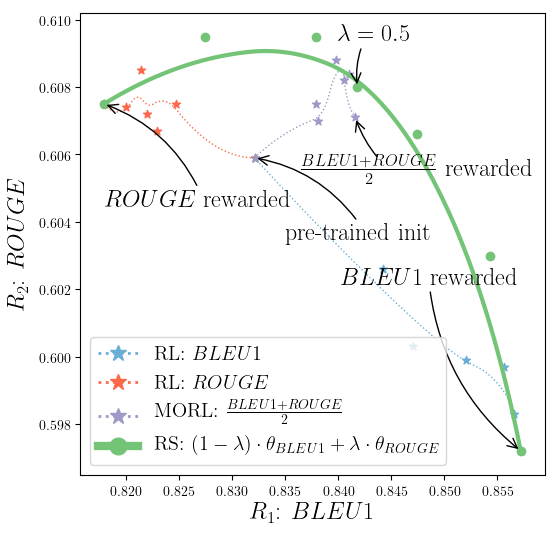

In [46]:
fig_dr = plot_captioning(
    [
        e2e_bleu.l_step, e2e_bleu.l_wa, e2e_rouge.l_step, e2e_rouge.l_wa,
        e2e_bleurouge.l_step_rougebleu, e2e_bleurouge.l_wa_rougebleu
    ],
    key_x="Bleu_1",
    key_y="ROUGE_L",
    loc="lower left",
    dict_labels={
        0: r"RL: $BLEU1$",
        2: r"RL: $ROUGE$",
        4: r"MORL: $\frac{BLEU1+ROUGE}{2}$",
        5: r"RS: $(1-\lambda) \cdot \theta_{BLEU1} + \lambda \cdot \theta_{ROUGE}$"
    },
    fontsize="x-large",
    dict_annotation_to_loc={
        "1": (0.818, 0.605),
        "lambda": (0.84, 0.6099),
        "pt": (0.835, 0.604),
        "0": (0.857, 0.602),
        "01": (0.8365, 0.605)
    }
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_e2e_bleu1torouge.pdf", do_save=do_save)


['$R_1$: $BLEU1$', '$BLEU2$', '$BLEU3$', '$BLEU4$', '$R_2$: $ROUGE$', '$METEOR$', '$CIDEr$']


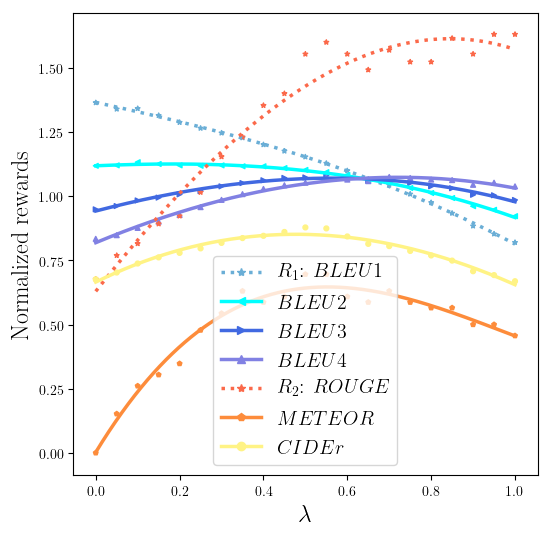

In [9]:
fig_dr = plot_scatter_captioning(
    l=fts_bleurouge.l_wa_epoch5, key_1="Bleu_1", key_2="ROUGE_L", order="3", key_x="lambda",
    legendtitle="no"
    # _dict_key_to_limit={"y": (-0.02, 1.75)},
)
plot.save_fig(
    fig=fig_dr,
    name="captioning/lambda_captioning_bleu1torouge.pdf",
    do_save=do_save,
)


In [ ]:
fig_dr = plot_captioning(
    [
        fts_bleu.l_step, fts_bleu.l_wa, fts_rouge.l_step, fts_rouge.l_wa_step5,
        fts_bleurouge.l_step, fts_bleurouge.l_wa_epoch5
    ],
    dict_labels={
        0: r"RL reward: $R_1$",
        2: r"RL reward: $R_2$",
        4: r"MORL: $\frac{R_1+R_2}{2}$",
        5: r"RS: $(1-\lambda) \theta_{R_1} + \lambda \theta_{R_2}$"
    },
    dict_annotation_to_loc={
        "01": (0.835, 0.6085),
        "1": (0.825, 0.6107),
        "pt": (0.825, 0.607),
        "0": (0.85, 0.606),
        "lambda": (0.845, 0.6105)
    },
    loc="lower left",
    key_x="Bleu_1",
    key_y="ROUGE_L",
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleu1torouge.pdf", do_save=do_save)

In [10]:
cmap_redgreenblue = "bwr"
# plot.matplotlib.colors.LinearSegmentedColormap.from_list(
#     "", [
#         (1, 0, 0),
#         (0, 0, 1),
#     ]
# )

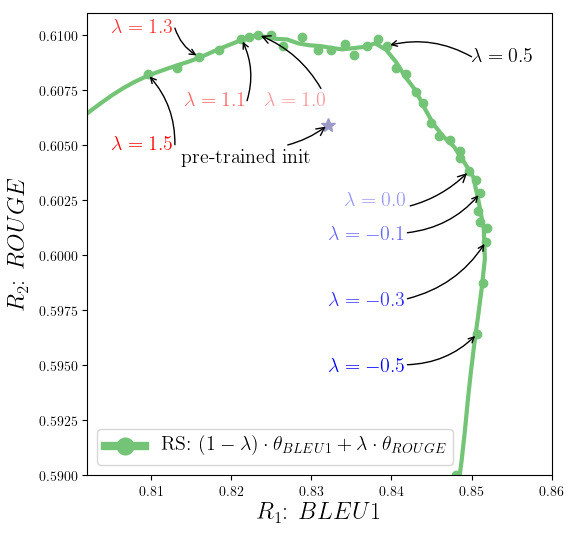

In [53]:
SIZE_EXTRA = "x-large"
fig_dr = plot_captioning(
    [
        fts_bleu.l_step, fts_bleu.l_extra, fts_rouge.l_step, fts_rouge.l_extra,
        fts_bleurouge.l_step, fts_bleurouge.l_extra
    ],
    key_x="Bleu_1",
    key_y="ROUGE_L",
    colormaps=["Blues", None, "Reds", None, None, cmap_redgreenblue],
    colors=[
        plot.get_color_from_cmap("Blues", dict_colormaps),
        plot.get_color_from_cmap("Blues", dict_colormaps),
        plot.get_color_from_cmap("Reds", dict_colormaps),
        plot.get_color_from_cmap("Reds", dict_colormaps),
        plot.get_color_from_cmap("Purples", dict_colormaps),
        plot.get_color_from_cmap("Greens", dict_colormaps),
    ],
    # keycolor="-lambda",
    order="savgol_3_1_quadratic",
    _dict_key_to_limit={
        "Bleu_1": [0.802, 0.86],
        "ROUGE_L": [0.59, 0.611],
        # "METEOR": [0.29, 0.32]
    },
    # labels=["Blues", None, "Reds", None, None, r"RS: $(1-\lambda) \cdot \theta_{BLEU1} + \lambda \theta_{ROUGE}$"],
    loc="lower left",
    # dict_labels={
    #     5: None
    #         # r"WA $\lambda$: ${label_x}$ $\to$ ${label_y}$".format(
    #         #     label_x="bleu1", label_y="rouge"
    #         # )
    # },
    list_indexes=[5],
    fontsize="x-large",
    do_annotate=False
)
key_x="Bleu_1"
key_y="ROUGE_L"
label_x = dict_key_to_label[key_x]
label_y = dict_key_to_label[key_y]

arrowprops.update({"relpos": (0.5, 1)})
plot.plt.plot(
    fts_bleu.l_step[0][key_x],
    fts_bleu.l_step[0][key_y],
    marker="*",
    color=plot.get_color_from_cmap("Purples", dict_colormaps),
    markersize=10
)

plot.plt.annotate(
    "pre-trained init",
    xy=(fts_bleu.l_step[0][key_x], fts_bleu.l_step[0][key_y]),
    xytext=(0.83, 0.604),
    ha='right',
    va="bottom",
    size=SIZE_EXTRA,
    # color= plot.get_color_from_cmap("Purples", dict_colormaps),
    arrowprops=arrowprops
)

colors = [plot.cm.get_cmap(cmap_redgreenblue)((i) / 10) for i in range(11)]

arrowprops.update({"relpos": (0.5, 0)})
plot.plt.annotate(
    r"$\lambda=0.0$",
    xy=(fts_bleu.l_step[-1][key_x], fts_bleu.l_step[-1][key_y]),
    xytext=(0.842, 0.602),
    ha='right',
    va="bottom",
    size=SIZE_EXTRA,
    arrowprops=arrowprops,
    color=colors[3]
)
arrowprops.update({"relpos": (1, 0.5)})
plot.plt.annotate(
    r"$\lambda=1.0$",
    xy=(fts_rouge.l_step[-1][key_x], fts_rouge.l_step[-1][key_y]),
    xytext=(0.832, 0.607),
    ha='right',
    va="center",
    size=SIZE_EXTRA,
    arrowprops=arrowprops,
    color=colors[7]
)

del arrowprops["relpos"]


xytext = (0.85, 0.609)
key = 4 + 1
arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)

plot.plt.annotate(
    r"$\lambda=0.5$",
    xy=xytext,
    xytext=xytext,
    ha='left',
    va="center",
    size=SIZE_EXTRA,
    # color=colors[key]
)

plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleurouge.l_extra)[key_x], get_at_coeff(fts_bleurouge.l_extra)[key_y]),
    xytext=xytext,
    arrowprops=arrowpropskey
)


xytext = (0.822, 0.607)
key = 7 + 1
arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)
arrowpropskey.update({"relpos": (1, 0.5)})
plot.plt.annotate(
    r"$\lambda=1.1$",
    xy=xytext,
    xytext=xytext,
    ha='right',
    va="center",
    size=SIZE_EXTRA,
    color=colors[key]
)

plot.plt.annotate(
    "",
    xy=(
        get_at_coeff(fts_bleurouge.l_extra,
                     coeff=1.1)[key_x], get_at_coeff(fts_bleurouge.l_extra, coeff=1.1)[key_y]
    ),
    xytext=xytext,
    arrowprops=arrowpropskey
)

xytext=(0.813, 0.6103)
key = 8 + 1
arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)
arrowpropskey.update({"relpos": (1, 0.5)})
plot.plt.annotate(
    r"$\lambda=1.3$",
    xy=xytext,
    xytext=xytext,
    ha='right',
    va="center",
    size=SIZE_EXTRA,
    color=colors[key]
)

plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleurouge.l_extra, coeff=1.3)[key_x], get_at_coeff(fts_bleurouge.l_extra, coeff=1.3)[key_y]),
    xytext=xytext,
    arrowprops=arrowpropskey
)

xytext = (0.813, 0.605)
key = 8 + 2
arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)
arrowpropskey.update({"relpos": (1, 0.5)})
plot.plt.annotate(
    r"$\lambda=1.5$",
    xy=xytext,
    xytext=xytext,
    ha='right',
    va="center",
    size=SIZE_EXTRA,
    color=colors[key]
)

plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleurouge.l_extra, coeff=1.5)[key_x], get_at_coeff(fts_bleurouge.l_extra, coeff=1.5)[key_y]),
    xytext=xytext,
    arrowprops=arrowpropskey
)


xytext = (0.842, 0.601)
key = 1 + 1
arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)
arrowpropskey.update({"relpos": (0.5, 1)})
plot.plt.annotate(
    r"$\lambda=-0.1$",
    xy=xytext,
    xytext=xytext,
    ha='right',
    va="center",
    size=SIZE_EXTRA,
    color=colors[key]
)

plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleurouge.l_extra, coeff=-0.1)[key_x], get_at_coeff(fts_bleurouge.l_extra, coeff=-0.1)[key_y]),
    xytext=xytext,
    arrowprops=arrowpropskey
)

xytext = (0.842, 0.598)
key = 0 + 1
arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)
arrowpropskey.update({"relpos": (1, 1)})

plot.plt.annotate(
    r"$\lambda=-0.3$",
    xy=xytext,
    xytext=xytext,
    ha='right',
    va="center",
    size=SIZE_EXTRA,
    color=colors[key]
)

plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleurouge.l_extra, coeff=-0.3)[key_x], get_at_coeff(fts_bleurouge.l_extra, coeff=-0.3)[key_y]),
    xytext=xytext,
    arrowprops=arrowpropskey
)

xytext = (0.842, 0.595)
key = 0
arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)
arrowpropskey.update({"relpos": (1, 1)})

plot.plt.annotate(
    r"$\lambda=-0.5$",
    xy=xytext,
    xytext=xytext,
    ha='right',
    va="center",
    size=SIZE_EXTRA,
    color=colors[key]
)

plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleurouge.l_extra, coeff=-0.5)[key_x], get_at_coeff(fts_bleurouge.l_extra, coeff=-0.5)[key_y]),
    xytext=xytext,
    arrowprops=arrowpropskey
)

plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleu1torouge_extra.pdf", do_save=do_save)

In [45]:
len(colors)

11

# bleu4 to rouge

In [ ]:
fig_dr = plot_scatter_captioning(
    l=fts_rougebleu4.l_wa,
    key_1="Bleu_4",
    key_2="ROUGE_L",
    order="3",
    key_x="lambda",
    _dict_key_to_limit={"y": (-0.02, 1.75)},
)
plot.save_fig(
    fig=fig_dr,
    name="captioning/lambda_captioning_bleu4torouge.pdf",
    do_save=do_save,
)


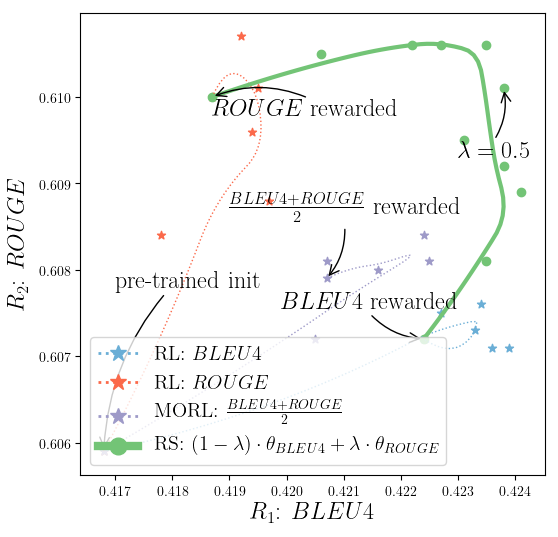

In [43]:
fig_dr = plot_captioning(
    [
        fts_bleu4.l_step,
        fts_bleu4.l_wa,
        fts_rouge.l_step,
        fts_rouge.l_wa_step5,
        fts_rougebleu4.l_step,
        fts_rougebleu4.l_wa,
    ],
    key_x="Bleu_4",
    loc="lower left",
    fontsize="x-large",
    key_y="ROUGE_L",
    _dict_key_to_label={"Bleu_4": r"$R_1$: $BLEU4$"},
    dict_annotation_to_loc={"lambda": (0.423, 0.6095), "01": (0.419, 0.6085), "pt": (0.417, 0.608), "0": (0.423, 0.6075)},
    
    # _dict_key_to_limit={"Bleu_4": [0.413,0.425]}
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleu4torouge.pdf", do_save=do_save)

In [ ]:
fig_dr = plot_scatter_captioning(
    l=e2e_bleu4rouge.l_wa,
    key_1="Bleu_4",
    key_2="ROUGE_L",
    _dict_key_to_limit={"y": (-0.02, 1.65)},
    order="3",
    key_x="1-lambda",
    dict_key_to_minmax=dict_key_to_minmax_e2e
)
plot.save_fig(
    fig=fig_dr,
    name="captioning/lambda_captioning_e2e_bleu4torouge.pdf",
    do_save=do_save,
)


In [ ]:
fig_dr = plot_captioning(
    [
        e2e_bleu4.l_step, e2e_bleu4.l_wa, e2e_rouge.l_step, e2e_rouge.l_wa, e2e_bleu4rouge.l_step,
        e2e_bleu4rouge.l_wa
    ],
    key_x="Bleu_4",
    key_y="ROUGE_L",
    _dict_key_to_label={"Bleu_4": r"$R_1$: $bleu4$"},
    dict_annotation_to_loc={
        "lambda": (0.423, 0.6095),
        "0": (0.425, 0.605),
        "pt": (0.414, 0.604),
        "01": (0.418, 0.6078)
    },

    # _dict_key_to_limit={"Bleu_4": [0.413, 0.425], "ROUGE_L": [0.6045, 0.611]}
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_e2e_bleu4torouge.pdf", do_save=do_save)

# CIDER

['$R_1$: $BLEU1$', '$BLEU2$', '$BLEU3$', '$BLEU4$', '$ROUGE$', '$METEOR$', '$R_2$: $CIDEr$']


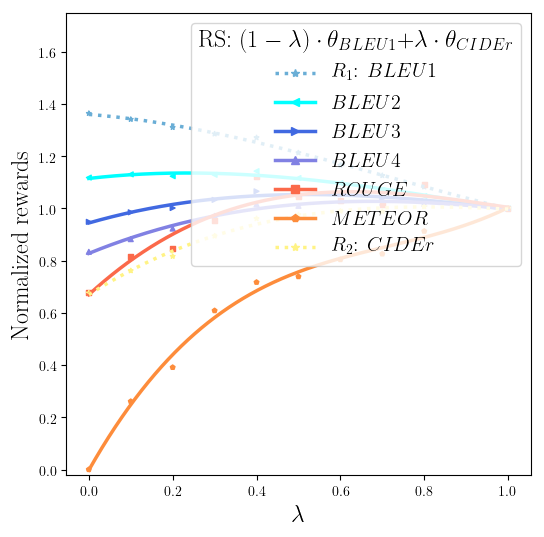

In [34]:
fig_dr = plot_scatter_captioning(
    l=fts_bleu.l_wa,
    key_1="Bleu_1",
    key_2="CIDEr",
    order="3",
    # loc="upper right",
    key_x="lambda",
    dict_key_to_minmax=dict_key_to_minmax_fts,
        _dict_key_to_limit={"y": (-0.02, 1.75)},
)
plot.save_fig(
    fig=fig_dr,
    name="captioning/lambda_captioning_bleu1tocider.pdf",
    do_save=do_save,
)


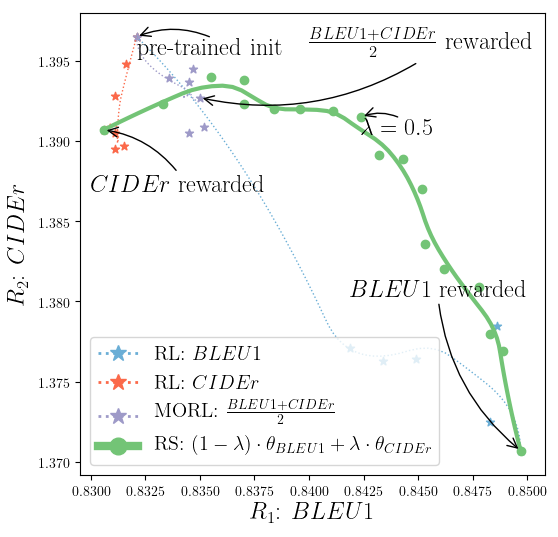

In [45]:
# [
#     fts_bleu.l_step,
#     fts_bleu.l_wa,
#     fts_cider.l_step,
#     fts_cider.l_wa,
#     e2e_cider.l_step,
#     fts_ciderbleu.l_step,
#     fts_ciderbleu.l_wa,
#     fts_rougecider.l_wa
# ],

fig_dr = plot_captioning(
    [
        fts_bleu.l_step,
        fts_bleu.l_wa,
        fts_cider.l_step,
        fts_cider.l_wa,
        fts_ciderbleu.l_step,
        fts_ciderbleu.l_wa,
    ],
    key_x="Bleu_1",
    loc="lower left",
    key_y="CIDEr",
    fontsize="x-large",
    dict_annotation_to_loc={
        "1": (0.83, 1.388),
        "01": (0.84, 1.395),
        "0": (0.85, 1.38)
    },
)
plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleu1tocider.pdf", do_save=do_save)

# Bleu rouge enriched

In [ ]:
# plot.plt.rcParams["figure.figsize"] = (6, 6)
# plot.SIZE = "large"
# plot.SIZE_AXIS = "xx-large"

In [12]:
key_x = "Bleu_1"
key_y = "ROUGE_L"

label_x = dict_key_to_label[key_x]
label_y = dict_key_to_label[key_y]

def plot_captioning_enriched(list_l, order="savgol_3_1_quadratic", dict_annotation_to_loc={}, annotate_lambda=False, do_annotate=True, **kwargs):
    plot.plt.rcParams["figure.figsize"] = (6, 6)
    fig_dr = plot.plot_key(
        list_l,
        key_x=key_x,
        key_y=key_y,
        order=order,
        **kwargs,
    )
    if do_annotate:
        arrowprops.update({"relpos": (0.5, 1)})
        if annotate_lambda != 0:
            plot.plt.annotate(
                "pre-trained init",
                xy=(fts_bleu.l_step[0][key_x], fts_bleu.l_step[0][key_y]),
                xytext=dict_annotation_to_loc.get("pt"),
                ha='left',
                va="top",
                size=SIZE_PLOT,
                arrowprops=arrowprops
            )
        arrowprops.update({"relpos": (0.5, 0)})
        plot.plt.annotate(
            r"${label_x}$".format(label_x=label_x) + " rewarded" if not annotate_lambda else r"$\mu=\lambda=0$",
            xy=(fts_bleu.l_step[-1][key_x], fts_bleu.l_step[-1][key_y]),
            xytext=dict_annotation_to_loc.get("0"),
            ha='right',
            va="bottom",
            size=SIZE_PLOT,
            arrowprops=arrowprops
        )
        arrowprops.update({"relpos": (0.5, 1)})
        plot.plt.annotate(
            r"${label_y}$".format(label_y=label_y) + " rewarded" if not annotate_lambda else r"$\mu=\lambda=1$",
            xy=(fts_rouge.l_step[-1][key_x], fts_rouge.l_step[-1][key_y]),
                xytext=dict_annotation_to_loc.get("1"),             
            ha='left',
            va="top",
            size=SIZE_PLOT,
            arrowprops=arrowprops
        )
    return fig_dr

['$R_1$: $BLEU1$', '$BLEU2$', '$BLEU3$', '$BLEU4$', '$R_2$: $ROUGE$', '$METEOR$', '$CIDEr$']


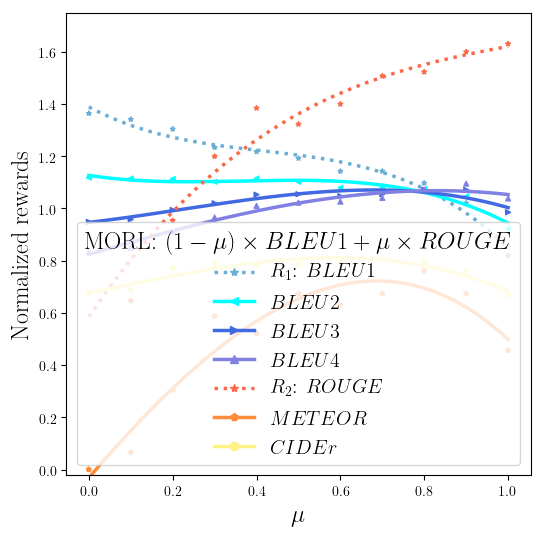

In [10]:
import copy

l_bleurouge_multi = [
    copy.deepcopy(fts_bleu.l_step[-1]),
    copy.deepcopy(fts_bleurouge.l_wa_91[-1]),
    copy.deepcopy(fts_bleurouge.l_step_bleu4rouge1[-1]),
    copy.deepcopy(fts_bleurouge.l_step_15[-1]),
    copy.deepcopy(fts_bleurouge.l_step_bleu3rouge2[-1]),
    copy.deepcopy(fts_bleurouge.l_step[-1]),
    copy.deepcopy(fts_bleurouge.l_step_bleu2rouge3[-1]),
    copy.deepcopy(fts_bleurouge.l_step_51[-1]),
    copy.deepcopy(fts_bleurouge.l_step_bleu1rouge4[-1]),
    copy.deepcopy(fts_bleurouge.l_wa_19[-1]),
    copy.deepcopy(fts_rouge.l_step[-1]),
]
coeffs = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for l, c in zip(l_bleurouge_multi, coeffs):
    l.update({"mu": c})
fig_dr = plot_scatter_captioning(
    l=l_bleurouge_multi,
    key_1="Bleu_1",
    key_2="ROUGE_L",
    order="3",
    key_x="mu",
    _dict_key_to_limit={"y": (-0.02, 1.75)},
    _dict_key_to_label={
        "mu": '$\mu$',
        "METEOR": "METEOR",
        "CIDEr": "CIDEr"
    },
    legendtitle=r"MORL: $(1-\mu) \times BLEU1 + \mu \times ROUGE$"
)
# plot.save_fig(
#     fig=fig_dr,
#     name="captioning/lambda_captioning_multibleu1rouge.pdf",
#     do_save=do_save,
# )

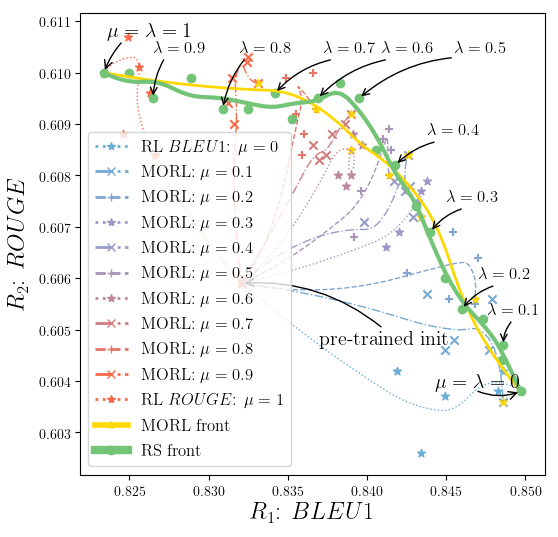

In [13]:
colors = [plot.cm.get_cmap(cmap_redpurpleblue)((9 - i) / 9) for i in range(11)]
colors+=["gold"] # plot.get_color_from_cmap("Purples", dict_colormaps)]
colors+=[plot.get_color_from_cmap("Greens", dict_colormaps)]
colors[3] = plot.cm.get_cmap("Purples")(0.5)
plot.MULTIPLYLEGENDMARKER=1
SIZE_PLOT = "x-large"
fig_dr = plot_captioning_enriched(
    [
        fts_bleu.l_step,
        fts_bleurouge.l_wa_91,
        fts_bleurouge.l_step_bleu4rouge1,
        fts_bleurouge.l_step_15,
        fts_bleurouge.l_step_bleu3rouge2,
        fts_bleurouge.l_step,
        fts_bleurouge.l_step_bleu2rouge3,
        fts_bleurouge.l_step_51,
        fts_bleurouge.l_step_bleu1rouge4,
        fts_bleurouge.l_wa_19,
        fts_rouge.l_step,
        l_bleurouge_multi,
        fts_bleurouge.l_wa_epoch5,
    ],
    annotate_lambda=True,
    labels=[
        r"RL $BLEU1$: $\mu=0$",
        r"MORL: $\mu=0.1$",
        r"MORL: $\mu=0.2$",
        r"MORL: $\mu=0.3$",
        r"MORL: $\mu=0.4$",
        r"MORL: $\mu=0.5$",
        r"MORL: $\mu=0.6$",
        r"MORL: $\mu=0.7$",
        r"MORL: $\mu=0.8$",
        r"MORL: $\mu=0.9$",
        r"RL $ROUGE$: $\mu=1$",
        r"MORL front",  #$(1-\mu) BLEU1$ $+$ $\mu ROUGE$",
        r"RS front",  # $(1-\lambda) \theta_{BLEU1} + \lambda \theta_{ROUGE}$"
    ],
    linestyles=[
        "dotted",
        "dashdot",
        "dashed",
        "dotted",
        "dashdot",
        "dashed",
        "dotted",
        "dashdot",
        "dashed",
        "dashdot",
        "dotted",
        "solid*",
        "solid",
    ],
    linewidths=[
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        1,
        2,
        3,
    ],
    colormaps=None,
    dict_annotation_to_loc={
        "pt": (0.837, 0.605),
        "1": (0.8236, 0.6110)
    },
    keycolor=None,
    # colors=[
    #     plot.get_color_from_cmap("Blues", dict_colormaps),
    #     plot.get_color_from_cmap("Blues_Greens", dict_colormaps),
    #     plot.get_color_from_cmap("Blues_Greens", dict_colormaps),
    #     plot.get_color_from_cmap("Greens", dict_colormaps),
    #     plot.get_color_from_cmap("Reds_Greens", dict_colormaps),
    #     plot.get_color_from_cmap("Reds", dict_colormaps),
    #     plot.get_color_from_cmap("Purples", dict_colormaps),
    # ],
    # order="connect",
    colors=colors,
    _dict_key_to_limit={
        # "Bleu_1": [0.82, 0.851],
        # "ROUGE_L": [0.601, 0.611],
        # "METEOR": [0.29, 0.32]
    },
    loc="lower left",
    fontsize="large"
)
xytext = (0.842, 0.6104)
arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)
arrowpropskey.update({"relpos": (0.5, 0)})

coeff = 0.1
plot.plt.annotate(
    r"$\lambda=0.1$",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y]),
    xytext=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x] - 0.001,  get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y] + 0.0005),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)

coeff = 0.2
plot.plt.annotate(
    r"$\lambda=0.2$",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y]),
    xytext=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x] + 0.001,  get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y] + 0.0005),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.3
plot.plt.annotate(
    r"$\lambda=0.3$",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y]),
    xytext=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x] + 0.001, get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y] + 0.0005),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.4
plot.plt.annotate(
    r"$\lambda=0.4$",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y]),
    xytext=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x] + 0.002, get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y] + 0.0005),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.5
xytext8=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=0.8)[key_x] + 0.002, get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=0.8)[key_y] + 0.001)
plot.plt.annotate(
    r"$\lambda=0.5$",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y]),
    xytext=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x] + 0.006, xytext8[1]),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.6
plot.plt.annotate(
    r"$\lambda=0.6$",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y]),
    xytext=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x] + 0.004, xytext8[1]),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.7
plot.plt.annotate(
    r"$\lambda=0.7$",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y]),
    xytext=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x] + 0.003, xytext8[1]),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowpropskey
)
coeff = 0.8
plot.plt.annotate(
    r"$\lambda=0.8$",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y]),
    xytext=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x] + 0.001, xytext8[1]),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowprops
)
coeff = 0.9
plot.plt.annotate(
    r"$\lambda=0.9$",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_y]),
    xytext=(get_at_coeff(fts_bleurouge.l_wa_epoch5, coeff=coeff)[key_x] + 0.00, xytext8[1]),
    ha='left',
    va="bottom",
    size=plot.SIZE,
    arrowprops=arrowprops
)
# plot.plt.annotate(
#     "MORL rewarded",
#     xy=xytext,
#     xytext=xytext,
#     ha='center',
#     va="bottom",
#     size="medium",
# )


# for l in [fts_bleurouge.l_step_bleu4rouge1, fts_bleurouge.l_step_15, fts_bleurouge.l_step_bleu3rouge2, fts_bleurouge.l_step, fts_bleurouge.l_step_bleu2rouge3, fts_bleurouge.l_step_51, fts_bleurouge.l_step_bleu1rouge4]:
#     plot.plt.annotate(
#         "",
#         xy=(l[-1][key_x], l[-1][key_y]),
#         xytext=xytext,
#         arrowprops=arrowpropskey
#     )

plot.save_fig(
    fig=fig_dr, name="captioning/pareto_captioning_bleu1torouge_multimu.pdf", do_save=do_save
)
plot.MULTIPLYLEGENDMARKER=2
SIZE_PLOT = "xx-large"


In [ ]:
len([l["lambda"] for l in fts_bleurouge.l_wa_epoch5])

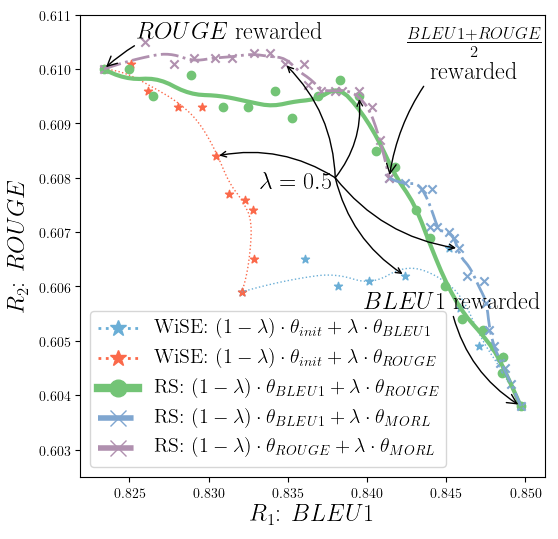

In [11]:
fig_dr = plot_captioning_enriched(
    [
        fts_bleu.l_step,
        fts_bleu.l_wa,
        fts_rouge.l_step,
        fts_rouge.l_wa_step5,
        fts_bleurouge.l_step,
        fts_bleurouge.l_wa_epoch5,
        fts_bleurouge.l_wa_bleu_multi,
        fts_bleurouge.l_wa_rouge_multi,
    ],
    list_indexes=[1, 3, 5, 6, 7],
    labels=[
        r"RL reward: $bleu1$",
        r"WiSE: $(1-\lambda)\cdot\theta_{init} + \lambda\cdot\theta_{BLEU1}$",
        r"RL reward: $rouge$",
        r"WiSE: $(1-\lambda)\cdot\theta_{init} + \lambda\cdot\theta_{ROUGE}$",
        r"RL multi-rewards: $\frac{bleu1 + rouge}{2}$",
        r"RS: $(1-\lambda)\cdot\theta_{BLEU1} + \lambda\cdot\theta_{ROUGE}$",
        r"RS: $(1-\lambda)\cdot\theta_{BLEU1} + \lambda\cdot\theta_{MORL}$",
        r"RS: $(1-\lambda)\cdot\theta_{ROUGE} + \lambda\cdot\theta_{MORL}$",
    ],
    colormaps=None,
    colors=[
        plot.cm.get_cmap("Blues")(0.5),
        plot.cm.get_cmap("Blues")(0.5),
        plot.cm.get_cmap("Reds")(0.5),
        plot.cm.get_cmap("Reds")(0.5),
        plot.cm.get_cmap("Purples")(0.5),
        plot.cm.get_cmap("Greens")(0.5),
        plot.cm.get_cmap(cmap_redpurpleblue)(4 / 5),
        plot.cm.get_cmap(cmap_redpurpleblue)(2 / 5)
    ],
    linestyles=[
        "dotted",
        "dotted",
        "dotted",
        "dotted",
        "dotted",
        "solid",
        "dashdot",
        "dashdot",
    ],
    linewidths=[
        1,
        1,
        1,
        1,
        1,
        3,
        2,
        2,
    ],
    _dict_key_to_limit={
        # "Bleu_1": [0.82, 0.852],
        "ROUGE_L": [0.6025, 0.611],
        # "METEOR": [0.29, 0.32]
    },
    dict_annotation_to_loc={
        "pt": (0.8245, 0.607),
        "1": (0.8255, 0.6109),
        "0": (0.851, 0.6055)
    },
    loc="lower left",
    do_annotate=True,
    fontsize="x-large"
)


label_xy = "{label_x} + {label_y}".format(label_x=label_x, label_y=label_y)
plot.plt.annotate(
    r"\begin{center}$\frac{BLEU1 + ROUGE}{{2}}$ \\rewarded\end{center}",
    xy=(fts_bleurouge.l_step[-1][key_x], fts_bleurouge.l_step[-1][key_y]),
    ha='left',
    va="center",
    xytext=(0.8425, 0.6102),
    size=SIZE_PLOT,
    arrowprops=arrowprops
)

xytext = (0.838, 0.608)
key = 8
arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)
arrowpropskey.update({"relpos": (1, 0.5)})
plot.plt.annotate(
    r"$\lambda=0.5$",
    xy=(0.838, 0.608),
    xytext=(0.8378, 0.6079),
    ha='right',
    va="center",
    size="xx-large",
)
for l in [
        fts_bleu.l_wa,
        fts_rouge.l_wa_step5,
        fts_bleurouge.l_wa_epoch5,
        fts_bleurouge.l_wa_bleu_multi,
        fts_bleurouge.l_wa_rouge_multi]:

    plot.plt.annotate(
        "",
        xy=(get_at_coeff(l, coeff=0.5)[key_x], get_at_coeff(l, coeff=0.5)[key_y]),
        xytext=xytext,
        arrowprops=arrowpropskey
    )

plot.save_fig(
    fig=fig_dr, name="captioning/pareto_captioning_bleu1torouge_multi.pdf", do_save=do_save
)


In [12]:
SIZE_PLOT

'xx-large'

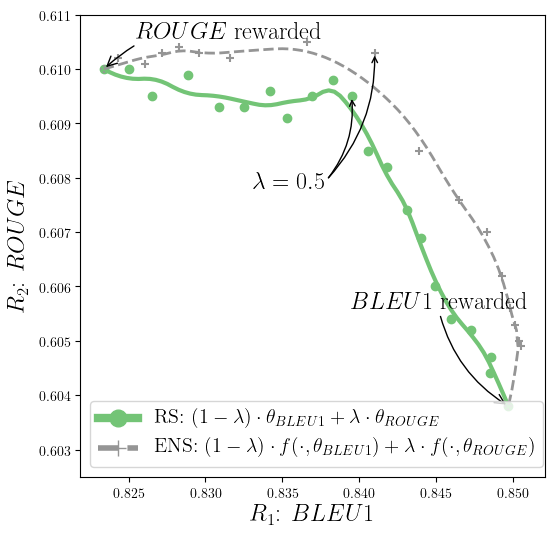

In [32]:
fig_dr = plot_captioning_enriched(
    [
        fts_bleu.l_step,
        fts_rouge.l_step,
        fts_bleurouge.l_step,
        fts_bleurouge.l_wa_epoch5,
        fts_bleurouge.l_ens,
        #fts_bleurouge.l_ens_step10
    ],
    list_indexes=[3, 4],
    labels=[
        r"RL: $BLEU1$",
        r"RL: $ROUGE$",
        r"MORL: $\frac{BLEU1 + ROUGE}{2}$",
        r"RS: $(1-\lambda)\cdot\theta_{BLEU1} + \lambda\cdot\theta_{ROUGE}$",
        r"ENS: $(1-\lambda)\cdot f(\cdot, \theta_{BLEU1}) + \lambda\cdot f(\cdot, \theta_{ROUGE})$",
        # r"ENS: $BLEU1$ $\to$ $ROUGE$ step10",
        None
    ],
    colormaps=["Blues", "Reds", "Purples", "Greens", "Greys"],
    do_annotate=True,
    annotate_lambda=0,
    linestyles=[
        "dotted",
        "dotted",
        "dotted",
        "solid",
        "dashed",
        "dashdot",
    ],
    linewidths=[
        1,
        1,
        1,
        3,
        2,
        0,
    ],
    # loc=(0., 0.43),
    loc="lower left",
    fontsize="x-large",
    # _dict_key_to_limit={
    #     # "Bleu_1": [0.82, 0.852],
    #     "ROUGE_L": [0.6025, 0.611],
    #     # "METEOR": [0.29, 0.32]
    # },
    # dict_annotation_to_loc={
    #     "pt": (0.8245, 0.607),
    #     "1": (0.8255, 0.61085),
    #     "0": (0.851, 0.6055)
    # },
    _dict_key_to_limit={
        # "Bleu_1": [0.82, 0.852],
        "ROUGE_L": [0.6025, 0.611],
        # "METEOR": [0.29, 0.32]
    },
    dict_annotation_to_loc={
        "pt": (0.8245, 0.607),
        "1": (0.8255, 0.6109),
        "0": (0.851, 0.6055)
    },
)

xytext =(0.838, 0.608)

arrowpropskey = dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', linewidth=1, shrinkA=0)
arrowpropskey.update({"relpos": (1, 0.5)})
plot.plt.annotate(
    r"$\lambda=0.5$",
    xy=(0.838, 0.608),
    xytext=(0.8378, 0.6079),
    ha='right',
    va="center",
    size="xx-large",
)


plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5)[key_y]),
    xytext=xytext,
    arrowprops=arrowprops
)
plot.plt.annotate(
    "",
    xy=(
        get_at_coeff(fts_bleurouge.l_ens)[key_x], get_at_coeff(fts_bleurouge.l_ens
                                                                    )[key_y]
    ),
    xytext=xytext,
    arrowprops=arrowprops
)

plot.save_fig(
    fig=fig_dr, name="captioning/pareto_captioning_bleu1torouge_ens.pdf", do_save=do_save
)

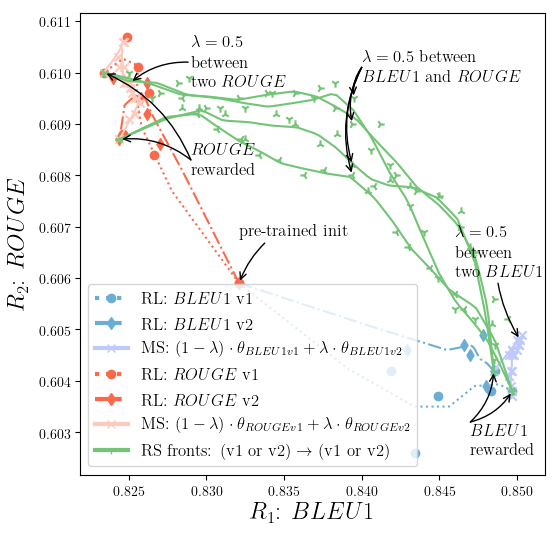

In [21]:
plot.MULTIPLYLEGENDMARKER = 1
plot.plt.rcParams["figure.figsize"] = (6, 6)
fig_dr = plot.plot_key(
    [
        fts_bleu.l_step,
        fts_bleu.l_stepv2,
        fts_bleu.l_wa,
        fts_bleu.l_soup,
        fts_rouge.l_step,
        fts_rouge.l_stepv2,
        fts_rouge.l_wa_step5,
        fts_rouge.l_soup,
        fts_bleurouge.l_step,
        fts_bleurouge.l_wa_epoch5,
        fts_bleurouge.l_wa_v22,
        fts_bleurouge.l_wa_v12,
        fts_bleurouge.l_wa_v21,
    ],
    fontsize="large",
    list_indexes=[0, 1, 3, 4, 5, 7, -4, -3, -2, -1],
    labels=[
        r"RL: $BLEU1$ v1", r"RL: $BLEU1$ v2", r"WA S: $init \to {label_x}$".format(label_x=label_x),
        r"MS: $(1-\lambda) \cdot \theta_{BLEU1v1} + \lambda\cdot \theta_{BLEU1v2}$",
        r"RL: $ROUGE$ v1", r"RL: $ROUGE$ v2", r"MS: $init \to {label_y}$".format(label_y=label_y),
        r"MS: $(1-\lambda) \cdot \theta_{ROUGEv1} + \lambda\cdot\theta_{ROUGEv2}$",
        r"MORL: $\frac{BLEU1 + ROUGE}{2}$", r"RS fronts: (v1 or v2) $\to$ (v1 or v2)", None, None,
        None
    ],
    colormaps=None,
    keycolor=None,
    colors=[
        plot.get_color_from_cmap("Blues", dict_colormaps),
        plot.get_color_from_cmap("Blues", dict_colormaps),
        plot.get_color_from_cmap("Blues", dict_colormaps),
        plot.get_color_from_cmap("Blues_Greens", dict_colormaps),
        plot.get_color_from_cmap("Reds", dict_colormaps),
        plot.get_color_from_cmap("Reds", dict_colormaps),
        plot.get_color_from_cmap("Reds", dict_colormaps),
        plot.get_color_from_cmap("Reds_Greens", dict_colormaps),
        plot.get_color_from_cmap("Purples", dict_colormaps),
        plot.get_color_from_cmap("Greens", dict_colormaps),
        plot.get_color_from_cmap("Greens", dict_colormaps),
        plot.get_color_from_cmap("Greens", dict_colormaps),
        plot.get_color_from_cmap("Greens", dict_colormaps),
    ],
    linestyles=[
        "dotted", "dashdot", "dashdot", "solid", "dotted", "dashdot", "dashdot", "solid", "dotted",
        "solid", "solid", "solid", "solid"
    ],
    markers=["o", "d", "d", "x", "o", "d", "d", "x", "o", "1", "2", "3", "4"],
    _dict_key_to_limit={
        # "Bleu_1": [0.821, 0.853],
        # "ROUGE_L": [0.609, 0.611],
        # "METEOR": [0.29, 0.32]
    },
    loc="lower left",
    key_x=key_x,
    key_y=key_y,
    order="savgol_3_1_slinear"
)
arrowprops.update({"relpos": (0.5, 1)})
plot.plt.annotate(
    "pre-trained init",
    xy=(fts_bleu.l_step[0][key_x], fts_bleu.l_step[0][key_y]),
    xytext=(fts_bleu.l_step[0][key_x], fts_bleu.l_step[0][key_y] + 0.001),    
    ha='left',
    va="center",
    size="large",
    arrowprops=arrowprops
)

xytext=(0.847, 0.6032)

# arrowprops.update({"relpos": (0, 1)})
plot.plt.annotate(
    r"${label_x}$".format(label_x=label_x) + "\nrewarded",
    xy=xytext,
    xytext=xytext,
    ha='left',
    va="top",
    size="large",
)

arrowprops.update({"relpos": (0.5, 1)})
plot.plt.annotate(
    r"$\lambda=0.5$" + "\nbetween\n" + r"two $BLEU1$",
    xy=(get_at_coeff(fts_bleu.l_soup)[key_x], get_at_coeff(fts_bleu.l_soup)[key_y]),
    xytext=(0.846, 0.6065),
    size="large",
    ha='left',
    va="center",
    arrowprops=arrowprops
)

plot.plt.annotate(
    "",
    xy=(fts_bleu.l_step[-1][key_x], fts_bleu.l_step[-1][key_y]),
    xytext=xytext,
    size="large",
    arrowprops=arrowprops
)

plot.plt.annotate(
    "",
    xy=(fts_bleu.l_stepv2[-1][key_x], fts_bleu.l_stepv2[-1][key_y]),
    xytext=xytext,
    size="large",
    arrowprops=arrowprops
)



xytext=(0.829, 0.6083)


plot.plt.annotate(
    r"${label_y}$".format(label_y=label_y) + "\nrewarded",
    xy=xytext,
    xytext=xytext,
    ha='left',
    va="center",
    size="large",
)

arrowprops.update({"relpos": (0., 0.5)})
plot.plt.annotate(
    r"$\lambda=0.5$" + "\nbetween\n" + r"two $ROUGE$",
    xy=(get_at_coeff(fts_rouge.l_soup)[key_x], get_at_coeff(fts_rouge.l_soup)[key_y]),
    xytext=(0.829, 0.6102),
    size="large",
    ha='left',
    va="center",
    arrowprops=arrowprops
)

plot.plt.annotate(
    "",
    xy=(fts_rouge.l_step[-1][key_x], fts_rouge.l_step[-1][key_y]),
    xytext=xytext,
    size="large",
    ha='left',
    va="center",
    arrowprops=arrowprops
)

plot.plt.annotate(
    "",
    xy=(fts_rouge.l_stepv2[-1][key_x], fts_rouge.l_stepv2[-1][key_y]),
    xytext=xytext,
    size="large",
    ha='left',
    va="center",
    arrowprops=arrowprops
)



xytext = (0.840, 0.6101)

plot.plt.annotate(
    r"$\lambda=0.5$" + " between\n" + r"$BLEU1$ and $ROUGE$",
    xy=xytext,
    xytext=xytext,
    ha='left',
    va="center",
    size="large",
)

plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleurouge.l_wa_epoch5)[key_x], get_at_coeff(fts_bleurouge.l_wa_epoch5)[key_y]),
    xytext=xytext,
    size="large",
    arrowprops=arrowprops
)
plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleurouge.l_wa_v22)[key_x], get_at_coeff(fts_bleurouge.l_wa_v22)[key_y]),
    xytext=xytext,
    size="large",
    arrowprops=arrowprops
)
plot.plt.annotate(
    "",
    xy=(get_at_coeff(fts_bleurouge.l_wa_v12)[key_x], get_at_coeff(fts_bleurouge.l_wa_v12)[key_y]),
    xytext=xytext,
    size="large",
    arrowprops=arrowprops
)
plot.plt.annotate(
    "",
    xy=(
        get_at_coeff(fts_bleurouge.l_wa_v21)[key_x], get_at_coeff(fts_bleurouge.l_wa_v21
                                                                    )[key_y]
    ),
    xytext=xytext,
    size="large",
    arrowprops=arrowprops
)

plot.save_fig(fig=fig_dr, name="captioning/pareto_captioning_bleu1torouge_soup.pdf", do_save=do_save)
plot.MULTIPLYLEGENDMARKER = 2